# Lab 6c - Spatializing Classic Clustering Methods

This notebook illustrates two ways in which spatial constraints can be introduced into classic clustering methods.

It is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
As such, the results of a classic clustering method like K-Means typically do not form spatially connected clusters, i.e., clusters for which the elements are spatially contiguous. In later notebooks, we cover methods to impose *hard* spatial constraints to a clustering method. Here, we illustrate a way to impose *soft* spatial constraints, in the sense that the solution is *nudged* towards a spatially contiguous set, but this is not necessarily satisfied.

First, we show a simple *regionalization* method by applying a classic clustering method to the centroid coordinates of spatial units. We already illustrated an example of this in the K-Medoids notebook. Here, we will apply K-Means to the centroids.

A second approach adds the centroid coordinates as additional features to the clustering procedure. This pushes the solution to a more spatially contiguous one, but it is only a soft constraint.

The empirical illustration uses the examples in Chapter 9 of the Spatial Cluster book. This Chapter also includes two additional methods that are primarily for pedagogical purposes to illustate the trade offs involved in imposing spatial constraints. Since they are non-standard, they are not considered here.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the same specification as in the previous notebooks:

In addition to the usual geopandas, we again import  `StandardScaler` from `sklearn.preprocessing`, and `KMeans` from `sklearn.cluster`. We also again import `cluster_stats`, `cluster_fit` and `cluster_map` from the `spatial_cluster_course` utility module.

In [1]:
import geopandas as gpd

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from spatial_cluster_course import cluster_stats, cluster_fit, cluster_map

### Load data

To illustrate the methods in this final set of notebooks devoted to the spatial perspective, we will use the *Ceara Zika* GeoDa sample data set with information on Zika and microcephaly incidence as well as a number of socio-economic indicators. The observations are for 184 municipios in the Brazilian state of Ceara. Detailed source and information is available at https://geodacenter.github.io/data-and-lab/Ceara-Zika/.

The following files will be used:
- **ceara.shp,shx,dbf,prj**: shape file (four files) for 184 municipios

We follow the usual practice of setting a path (if needed), reading the data from the shape file and a quick check of its contents (`head`).

In [2]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Chicago community area data:
dfs = gpd.read_file(path+"ceara/ceara.shp")
print(dfs.shape)
dfs.head(3)

(184, 36)


,code7,mun_name,state_init,area_km2,state_code,micro_code,micro_name,inc_mic_4q,inc_zik_3q,inc_zik_2q,...,gdp,pop,gdpcap,popdens,zik_1q,ziq_2q,ziq_3q,zika_d,mic_d,geometry
0,2300101.0,Abaiara,CE,180.833,23,23019,19Âª RegiÃ£o Brejo Santo,0.000000,0.0,0.00,...,35974.0,10496.0,3.427,58.043,0.0,0.0,0.0,0.0,0.0,"POLYGON ((5433729.65 9186242.97, 5433688.546 9..."
1,2300150.0,Acarape,CE,130.002,23,23003,3Âª RegiÃ£o MaracanaÃº,6.380399,0.0,0.00,...,68314.0,15338.0,4.454,117.983,0.0,0.0,0.0,0.0,1.0,"POLYGON ((5476916.288 9533405.667, 5476798.561..."
2,2300200.0,AcaraÃº,CE,842.471,23,23012,12Âª RegiÃ£o AcaraÃº,0.000000,0.0,1.63,...,309490.0,57551.0,5.378,68.312,0.0,1.0,0.0,1.0,0.0,"POLYGON ((5294389.783 9689469.144, 5294494.499..."


In [4]:
# the full set of variables
print(list(dfs.columns))

['code7', 'mun_name', 'state_init', 'area_km2', 'state_code', 'micro_code', 'micro_name', 'inc_mic_4q', 'inc_zik_3q', 'inc_zik_2q', 'inc_zik_1q', 'prim_care', 'ln_gdp', 'ln_pop', 'mobility', 'environ', 'housing', 'sanitation', 'infra', 'acu_zik_1q', 'acu_zik_2q', 'acu_zik_3q', 'pop_zikv', 'acu_mic_4q', 'pop_micro', 'lngdpcap', 'gdp', 'pop', 'gdpcap', 'popdens', 'zik_1q', 'ziq_2q', 'ziq_3q', 'zika_d', 'mic_d', 'geometry']


#### Municipio centroids

As in Chapter 9 of Anselin (2024) (https://lanselin.github.io/introbook_vol2/CHspatialclassicclustering.html), we will use the centroids of the municipios for our example. 

As in the K-Medoids notebook, we use the GeoPandas `centroid` attribute applied to our geodataframe, then extract the x and y coordinates and add them as new variables. We rescale them by 1000 to keep the distance units manageable. Since the original coordinates are projected, it is appropriate to apply Euclidean distance.

We also compute the scaling factor for `GeoDa` compatibility and set the number of clusters to 12.

In [5]:
cent = dfs.centroid
dfs['X'] = cent.x / 1000
dfs['Y'] = cent.y / 1000
n = dfs.shape[0]
nn = (n - 1.0)/n
n_clusters = 12

## K-Means on Centroid Coordinates

We first illustrate a straightforward application of K-Means to the centroids of the municipios. We define `data_cluster` as a subset of the geodataframe with just the coordinates and apply the `StandardScaler` and the `GeoDa` rescaling to create the input array `X`.

In [6]:
data_cluster = dfs[['X','Y']]
X0 = StandardScaler().fit_transform(data_cluster)
X = X0 * nn

We now apply `KMeans` with the usual arguments (see previous notebook for details) and obtain the cluster labels as `labels_`. We then apply `cluster_stats`, `cluster_fit` and `cluster_map` to characterize the results.

    Labels  Cardinality
0        0           17
1        1           22
2        2           31
3        3           19
4        4           11
5        5           11
6        6           17
7        7            7
8        8           17
9        9           12
10      10            8
11      11           12

Total Sum of Squares (TSS): 366.0
Within-cluster Sum of Squares (WSS) for each cluster: [1.594 2.974 3.464 1.904 1.274 1.033 2.376 1.051 1.944 1.514 1.175 1.206]
Total Within-cluster Sum of Squares (WSS): 21.508
Between-cluster Sum of Squares (BSS): 344.492
Ratio of BSS to TSS: 0.941


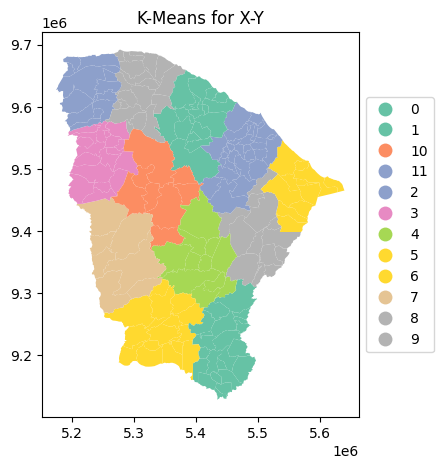

In [7]:
kmeans = KMeans(n_clusters=n_clusters, n_init = 150, init='k-means++', random_state=1234567).fit(X)
cluster_labels = kmeans.labels_
print(cluster_stats(cluster_labels))
clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels,
                      correct=True,n_clusters=n_clusters)
cluster_map(dfs,cluster_labels,title="K-Means for X-Y",cmap='Set2')

The results show a very nice regionalization, with good separation for BSS/TSS of 0.941. The resulting regions can then be used for data aggregation or as fixed effects variables in a spatial regression, among several other possibilities.

Similar results can be obtained by applying other classic clustering methods to the coordinates. This is not pursued further.

## K-Means with Coordinates as Additional Features

A *soft* spatial constraint is introduced by adding the X-Y coordinates to the regular features. We illustrate this for K-Means.

We create two lists with cluster variables from the Ceara data set, following the example in Section 9.3.1. of the Spatial Cluster book. In the first list (`clust_vars1`), we include six socio-economic indicators: mobility, environ, housing, sanitation, infra, and gdpcap. The second list (`clust_vars2`) also contains X and Y.

In [8]:
clust_vars1 = ["mobility","environ","housing","sanitation","infra","gdpcap"]
clust_vars2 = clust_vars1 + ["X","Y"]

### K-Means with Features Only

We proceed in the by now familiar manner to create `data_cluster1` as a subset of the geodataframe, and apply the `StandardScaler` to obtain the input matrix `X`. We then carry out `KMeans` with the usual arguments and summarize the results.

In [9]:
data_cluster1 = dfs[clust_vars1]
X0 = StandardScaler().fit_transform(data_cluster1)
X = X0 * nn

    Labels  Cardinality
0        0            9
1        1           23
2        2           28
3        3            7
4        4            4
5        5           11
6        6           19
7        7            4
8        8           28
9        9           11
10      10           20
11      11           20

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [22.763 40.907 34.245 27.094 11.088 22.647 36.175 22.227 46.061 25.763
 23.724 36.154]
Total Within-cluster Sum of Squares (WSS): 348.847
Between-cluster Sum of Squares (BSS): 749.153
Ratio of BSS to TSS: 0.682


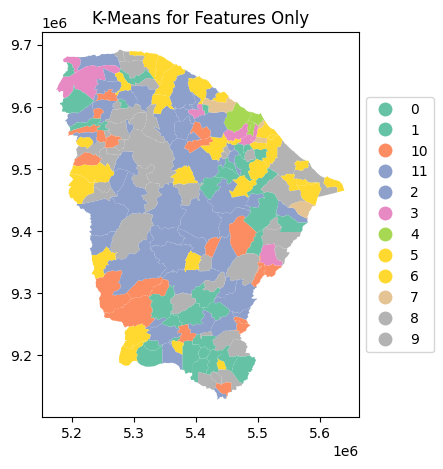

In [10]:
kmeans = KMeans(n_clusters=n_clusters, n_init = 150, init='k-means++', random_state=1234567).fit(X)
cluster_labels1 = kmeans.labels_
print(cluster_stats(cluster_labels1))
clusfit = cluster_fit(data=data_cluster1,clustlabels=cluster_labels1,
                      correct=True,n_clusters=n_clusters)
cluster_map(dfs,cluster_labels1,title="K-Means for Features Only",cmap='Set2')

The clusters are not identical as the solution obtained with `GeoDa`, but the results are close. The fit is quite good, with a BSS/TSS ratio of 0.682. However, there is very little *spatial* clustering. Cluster 4 is the only one that turns out to be spatially contiguous, consisting of 4 municipios surrounding the main city of Fortaleza. However, in contrast, for cluster 7, which also consists of 4 units, the four entities are totally disconnected in space.

### K-Means with X-Y Included as Features

We now include the X and Y coordinates among the features, but otherwise proceed in exactly the same way as before.

In [11]:
data_cluster2 = dfs[clust_vars2]
X0 = StandardScaler().fit_transform(data_cluster2)
X = X0 * nn

    Labels  Cardinality
0        0            7
1        1           18
2        2           35
3        3            4
4        4           30
5        5            8
6        6           13
7        7           21
8        8           17
9        9            4
10      10           16
11      11           11

Total Sum of Squares (TSS): 1464.0
Within-cluster Sum of Squares (WSS) for each cluster: [20.94  56.285 93.441 23.814 75.649 34.481 43.167 64.971 54.937 11.152
 57.568 18.649]
Total Within-cluster Sum of Squares (WSS): 555.055
Between-cluster Sum of Squares (BSS): 908.945
Ratio of BSS to TSS: 0.621


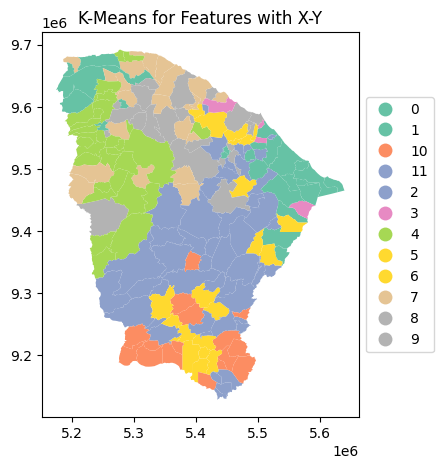

In [12]:
kmeans = KMeans(n_clusters=n_clusters, n_init = 150, init='k-means++', random_state=1234567).fit(X)
cluster_labels2 = kmeans.labels_
print(cluster_stats(cluster_labels2))
clusfit = cluster_fit(data=data_cluster2,clustlabels=cluster_labels2,
                      correct=True,n_clusters=n_clusters)
cluster_map(dfs,cluster_labels2,title="K-Means for Features with X-Y",cmap='Set2')

The results show more of a spatial grouping, although the solution is by no means fully contiguous. The price we pay for the inclusion of the coordinates is a decline of BSS/TSS to 0.621.